In [189]:
import  pandas as pd

In [190]:
data_hiring = pd.read_csv('../data/processed/hr_hiring_funnel.csv')
data_hiring

,applicant_id,source,stage,stage_date
0,A2000,Company Website,Applied,2024-03-18
1,A2000,LinkedIn,Phone Screen,2024-03-08
2,A2000,Job Fair,Interview,2024-02-21
3,A2001,Company Website,Applied,2024-01-27
4,A2001,LinkedIn,Phone Screen,2024-01-28
...,...,...,...,...
603,A2198,Referral,Offer,2024-02-16
604,A2199,Job Fair,Applied,2024-03-16
605,A2199,Company Website,Phone Screen,2024-03-16
606,A2199,Company Website,Interview,2024-02-16


In [191]:
data_hiring_offer = data_hiring[(data_hiring['stage'] == 'Offer')]
data_hiring_offer.head(10)

,applicant_id,source,stage,stage_date
6,A2001,Job Fair,Offer,2024-02-05
12,A2003,Referral,Offer,2024-03-14
26,A2009,Company Website,Offer,2024-01-21
37,A2012,Referral,Offer,2024-03-14
41,A2013,Company Website,Offer,2024-03-09
51,A2016,Company Website,Offer,2024-03-17
62,A2021,Referral,Offer,2024-03-08
67,A2022,Referral,Offer,2024-03-13
73,A2024,Job Fair,Offer,2024-01-27
77,A2025,Company Website,Offer,2024-02-13


In [192]:
data_hiring_hired = data_hiring[(data_hiring['stage'] == 'Hired')]
data_hiring_hired.head(10)

,applicant_id,source,stage,stage_date
27,A2009,Company Website,Hired,2024-01-09
42,A2013,Referral,Hired,2024-02-18
52,A2016,LinkedIn,Hired,2024-02-26
63,A2021,Company Website,Hired,2024-02-11
82,A2026,Company Website,Hired,2024-03-21
110,A2034,LinkedIn,Hired,2024-03-25
143,A2047,Company Website,Hired,2024-01-25
152,A2049,LinkedIn,Hired,2024-02-29
157,A2050,Referral,Hired,2024-01-31
164,A2052,LinkedIn,Hired,2024-03-27


In [193]:
# Group by 'source' then count the offer stage count
data_hiring_offer_grouped = data_hiring_offer.groupby(['source']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_hiring_offer_grouped

,source,count
0,Company Website,26
1,Job Fair,24
3,Referral,19
2,LinkedIn,17


In [194]:
# Group by 'source' then count the heired stage count
data_hiring_hired_grouped = data_hiring_hired.groupby(['source']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_hiring_hired_grouped

,source,count
2,LinkedIn,20
0,Company Website,16
3,Referral,6
1,Job Fair,5


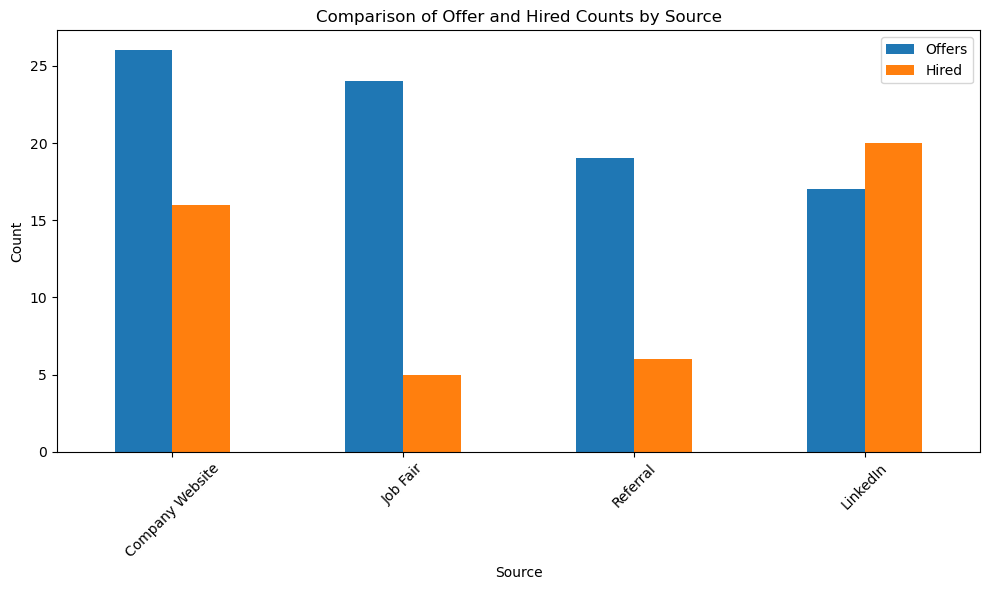

In [195]:
import matplotlib.pyplot as plt

# Merge the two datasets on 'source'
comparison_data = data_hiring_offer_grouped.merge(data_hiring_hired_grouped, on='source', suffixes=('_offer', '_hired'))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data.plot(x='source', y=['count_offer', 'count_hired'], kind='bar', ax=ax)
plt.title('Comparison of Offer and Hired Counts by Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['Offers', 'Hired'])
plt.tight_layout()
plt.show()

In [196]:
# Count the number of applicants in each stage
stage_counts = data_hiring.groupby('stage').size().reset_index(name='count')

# Calculate the drop-off rate between stages
stage_counts['drop_rate'] = stage_counts['count'].diff(-1) / stage_counts['count']

# Find the stage with the highest drop-off rate
highest_drop_stage = stage_counts.loc[stage_counts['drop_rate'].idxmax()]
print("Stage with the highest drop-off rate:")
print(highest_drop_stage)

Stage with the highest drop-off rate:
stage        Applied
count            200
drop_rate      0.765
Name: 0, dtype: object


In [197]:
# Convert 'stage_date' to datetime
data_hiring['stage_date'] = pd.to_datetime(data_hiring['stage_date'])

# Sort data by applicant_id and stage_date
data_hiring_sorted = data_hiring.sort_values(by=['applicant_id', 'stage_date'])

# Calculate the time difference between stages for each applicant
data_hiring_sorted['time_diff'] = data_hiring_sorted.groupby('applicant_id')['stage_date'].diff().dt.days
data_hiring_sorted

# Calculate the average time difference between stages
average_time_diff = data_hiring_sorted['time_diff'].mean()
print(f"Average time between stages: {average_time_diff:.2f} days")

Average time between stages: 17.81 days


In [198]:
# calculate the percentage of applicants in each stage
stage_counts['percentage'] = (stage_counts['count'] / stage_counts['count'].sum()) * 100

# show the percentage of applicants in each stage
stage_counts[['stage', 'percentage']]

,stage,percentage
0,Applied,32.894737
1,Hired,7.730263
2,Interview,19.243421
3,Offer,14.144737
4,Phone Screen,25.986842


In [199]:
# Filter 'Applied' and 'Hired' data
applied_data = data_hiring_sorted[data_hiring_sorted['stage'] == 'Applied']
hired_data = data_hiring_sorted[data_hiring_sorted['stage'] == 'Hired']

# Keep only the first occurrence of each stage per applicant
applied_data_first = applied_data.sort_values('stage_date').drop_duplicates('applicant_id', keep='first')
hired_data_first = hired_data.sort_values('stage_date').drop_duplicates('applicant_id', keep='first')

# Merge and calculate duration
merged_data = applied_data_first.merge(hired_data_first, on='applicant_id', suffixes=('_applied', '_hired'))
merged_data['total_time'] = (merged_data['stage_date_hired'] - merged_data['stage_date_applied']).dt.days

# Filter out invalid (negative) durations
merged_data = merged_data[merged_data['total_time'] >= 0]

# Compute average
average_total_time = merged_data['total_time'].mean()
print(f"Average total time from application to hiring: {average_total_time:.2f} days")


Average total time from application to hiring: 20.67 days
